In [1]:
import sys

sys.path.insert(0, "..")

In [2]:
import itertools
import math
import random
from typing import Iterable

from matplotlib import pyplot as plt
from matplotlib.axes import Axes
from matplotlib.collections import PolyCollection
from matplotlib.lines import Line2D

from funbin.einstein import aperiodic_monotile
from funbin.geometry import Box, LineSegment, Point, Polygon, SpatialIndex

In [3]:
def as_line2d(ls: LineSegment, **kw) -> Line2D:
    kw.setdefault("marker", ".")
    return Line2D([ls[0].x, ls[1].x], [ls[0].y, ls[1].y], **kw)

In [4]:
tiles = aperiodic_monotile(niter=3)
print(len(tiles))


def plot_tiles(ax: Axes):
    ax.add_collection(PolyCollection([p.verts for p in tiles], edgecolor="lightgray", facecolor="none"))

377


In [5]:
tiles_index = SpatialIndex.from_polygons(tiles, bins=len(tiles))

In [6]:
border_edges: list[LineSegment] = []
for t in tiles:
    for start, end in t.edges:
        vec = end - start
        small_normal = Point(vec.y, -vec.x)
        small_normal *= 1e-6 / small_normal.abs
        middle = start + vec / 2
        if tiles_index.is_inside_tiles(middle + small_normal) != tiles_index.is_inside_tiles(middle - small_normal):
            border_edges.append((start, end))


def plot_border(ax: Axes):
    for line in border_edges:
        ax.add_line(as_line2d(line, marker="none", color="red", linewidth=1))

In [137]:
from funbin.geometry import do_intersect

w_h_ratio = 2


def generate_inscribed_rect() -> Polygon:
    box = Box.bounding_all(tiles)

    angle = random.random() * 2 * math.pi
    print(360 * angle / 2 / math.pi)
    w_vec = Point(math.cos(angle), math.sin(angle))
    h_vec = Point(math.sin(angle), -math.cos(angle))

    while True:
        anchor = Point(
            x=box.anchor.x + random.random() * box.width,
            y=box.anchor.y + random.random() * box.height,
        )
        if tiles_index.is_inside_tiles(anchor):
            break

    w_init = box.width / 2

    for anchor_pos in range(4):
        print(anchor_pos, anchor)
        w = w_init
        w_step = w_init
        for iter in itertools.count():
            h = w / w_h_ratio
            match anchor_pos:
                case 0:
                    ll = anchor
                    ul = anchor + h * h_vec
                    ur = anchor + h * h_vec + w * w_vec
                    lr = anchor + w * w_vec
                case 1:
                    ll = anchor - h * h_vec
                    ul = anchor
                    ur = anchor + w * w_vec
                    lr = anchor + w * w_vec - h * h_vec
                case 2:
                    ll = anchor - h * h_vec - w * w_vec
                    ul = anchor - w * w_vec
                    ur = anchor
                    lr = anchor - h * h_vec
                case 3:
                    ll = anchor - w * w_vec
                    ul = anchor - w * w_vec + h * h_vec
                    ur = anchor + h * h_vec
                    lr = anchor
                case _:
                    raise RuntimeError("unreachable")

            rect = Polygon.from_points([ll, ul, ur, lr])
            is_inscribed = all(tiles_index.is_inside_tiles(p) for p in rect.vertices) and all(
                not any(do_intersect(edge, border_edge) for border_edge in border_edges) for edge in rect.edges
            )
            if is_inscribed:
                w += w_step
            else:
                w -= w_step
            w_step /= 2
            if iter > 10 and is_inscribed:
                if anchor_pos < 3:
                    anchor = rect.vertices[anchor_pos + 1]
                break
    return rect

98.11095311941736
0 (29.23, 9.96)
1 (33.22, 10.53)
2 (30.25, 31.41)
3 (0.16, 27.13)
Polygon(verts=array([[  8.73839505, -33.04094083],
       [ 38.82259664, -28.75345711],
       [ 30.2476292 ,  31.41494608],
       [  0.16342761,  27.12746236]]))


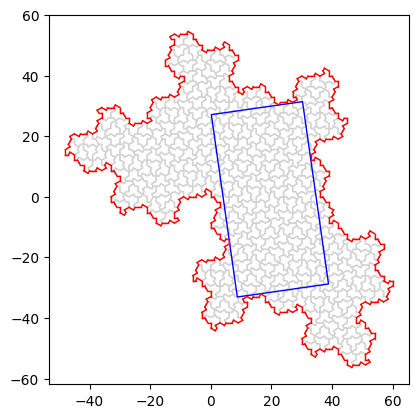

In [159]:
import matplotlib.patches

fig, ax = plt.subplots()
plot_border(ax)
plot_tiles(ax)
rect = generate_inscribed_rect()
print(rect)
ax.add_patch(matplotlib.patches.Polygon(rect.verts, facecolor="none", edgecolor="blue"))
Box.bounding_all(tiles).resized(1.1).fit_axes(ax)
ax.set_aspect("equal")

# Edge XOR algorithm (WIP)


In [ ]:
def length(ls: LineSegment) -> float:
    return math.sqrt((ls[1].x - ls[0].x) ** 2 + (ls[1].y - ls[0].y) ** 2)


def coord_on(ls: LineSegment, point: Point, eps_sqabs: float = 1e-8) -> float | None:
    v_line = ls[1] - ls[0]
    v_point = point - ls[0]
    coord = v_line.dot(v_point) / v_line.sqabs
    proj_sqabs = coord**2 * v_line.sqabs
    perp_sqabs = v_point.sqabs - proj_sqabs
    return coord if perp_sqabs < eps_sqabs else None


def is_in_bbox(ls: LineSegment, p: Point, eps: float = 1e-4) -> bool:
    xmin, xmax = (ls[0].x, ls[1].x) if ls[0].x < ls[1].x else (ls[1].x, ls[0].x)
    if not xmin - eps <= p.x <= xmax + eps:
        return False
    ymin, ymax = (ls[0].y, ls[1].y) if ls[0].y < ls[1].y else (ls[1].y, ls[0].y)
    return ymin - eps < p.y < ymax + eps


def xor_line_segments(ls1: LineSegment, ls2: LineSegment) -> Iterable[LineSegment] | None:
    if not is_in_bbox(ls1, ls2[0]) and not is_in_bbox(ls1, ls2[1]):
        return None
    c1 = coord_on(ls1, ls2[0])
    if c1 is None:
        return None
    c2 = coord_on(ls1, ls2[1])
    if c2 is None:
        return None

    if c1 > c2:
        c1, c2 = c2, c1

    eps = 1e-4
    if c1 > 1.0 - eps or c2 < 0.0 + eps:  # segments are collinear but do not overlap
        return None

    res = []
    if abs(c1) > eps:
        res.append((ls1[0], ls2[0]))
    if abs(c2 - 1) > eps:
        res.append((ls1[1], ls2[1]))
    return res

((0.00, 0.00), (2.00, 1.00))
((3.00, 1.50), (3.50, 1.75))


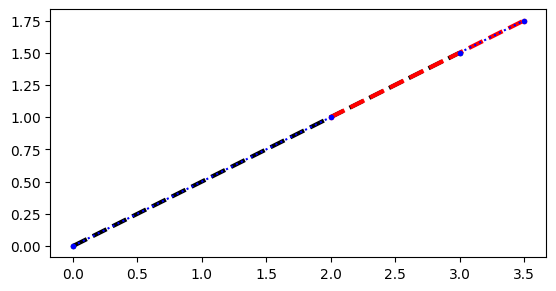

In [ ]:
fig, ax = plt.subplots()


l1 = (Point(0.0, 0.0), Point(3.0, 1.5))
l2 = (Point(2.0, 1.0), Point(3.5, 1.75))


ax.add_line(as_line2d(l1, color="black", linestyle="--", linewidth=3))
ax.add_line(as_line2d(l2, color="red", linestyle="--", linewidth=3))

for segment in xor_line_segments(l1, l2):
    print(segment)
    ax.add_line(as_line2d(segment, color="blue", linestyle=":"))

ax.set_aspect("equal")
Box.bounding(itertools.chain(l1, l2)).resized(1.1).fit_axes(ax)

In [ ]:
all_edges = list(itertools.chain.from_iterable([t.edges for t in tiles]))
index = SpatialIndex.from_line_segments(
    line_segments=all_edges,
    bins=len(tiles),
)
print(f"Total edges: {len(all_edges)}")

for iters in itertools.count():
    modified = False
    eid = 0
    while eid < len(index.items):
        to_remove: list[int] = []
        for i, j in index.item_bins[eid]:
            for other_candidate in index.items_in_bin[i][j]:
                # TODO: generic typing for index container
                left_after_xor = xor_line_segments(index.items[eid], index.items[other_candidate])  # type: ignore
                if left_after_xor is None:
                    continue
                for new_edge in left_after_xor:
                    index.append(new_edge)
                to_remove.append(other_candidate)
        if to_remove:
            modified = True
            to_remove.append(eid)
            to_remove.sort()
            for already_removed, remove_eid in enumerate(to_remove):
                index.pop(remove_eid - already_removed)
            eid -= len(to_remove)
        eid += 1
    if not modified:
        break

print(f"After {iters} iter left edges: {len(index.items)}")

Total edges: 5278


ValueError: list.remove(x): x not in list

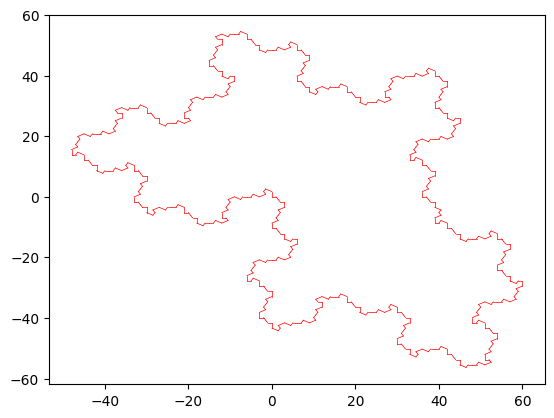

In [ ]:
fig, ax = plt.subplots()

for line in index.items:
    ax.add_line(as_line2d(line, marker="none", color="red", linewidth=0.5))

Box.bounding_all(tiles).resized(1.1).fit_axes(ax)